In [1]:
import numpy as np 
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt 


In [2]:
def saveWithPickle(obj, PATH_out, filename="saveWithPickle"):
    import pickle
    with open(f'{PATH_out}/{filename}.pickle', 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def loadFromPickle(dir_pickle):
    import pickle
    with open(dir_pickle, 'rb') as handle:
        unserialized_pickle = pickle.load(handle)
    return unserialized_pickle

def calcSampleEnrichment( T_Proportion, N_Proportion, epsilon=(0.1)**6 ):
    return np.log2( (T_Proportion+epsilon)/(N_Proportion+epsilon) )

## Load data

In [3]:
adata_joanito = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/Joanito.preprocessed.NanoMnT.ManualAnnot.h5ad')

In [4]:
dict_Identifier_to_lvl_1_CellType_1 = loadFromPickle('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType/B_and_T.lvl1.pickle')
dict_Identifier_to_lvl_1_CellType_2 = loadFromPickle('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType/Mye_and_Epi.lvl1.pickle')
dict_Identifier_to_lvl_1_CellType_3 = loadFromPickle('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType/Stromal.lvl1.pickle')

dict_Identifier_to_lvl_2_CellType_1 = loadFromPickle('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType/B_and_T.lvl2.pickle')
dict_Identifier_to_lvl_2_CellType_2 = loadFromPickle('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType/Mye_and_Epi.lvl2.pickle')
dict_Identifier_to_lvl_2_CellType_3 = loadFromPickle('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType/Stromal.lvl2.pickle')

dict_Identifier_to_lvl_1_CellType_Total,  dict_Identifier_to_lvl_2_CellType_Total = dict(), dict()

for k,v in dict_Identifier_to_lvl_1_CellType_1.items(): dict_Identifier_to_lvl_1_CellType_Total[k] = v
for k,v in dict_Identifier_to_lvl_1_CellType_2.items(): dict_Identifier_to_lvl_1_CellType_Total[k] = v
for k,v in dict_Identifier_to_lvl_1_CellType_3.items(): dict_Identifier_to_lvl_1_CellType_Total[k] = v

for k,v in dict_Identifier_to_lvl_2_CellType_1.items(): dict_Identifier_to_lvl_2_CellType_Total[k] = v
for k,v in dict_Identifier_to_lvl_2_CellType_2.items(): dict_Identifier_to_lvl_2_CellType_Total[k] = v
for k,v in dict_Identifier_to_lvl_2_CellType_3.items(): dict_Identifier_to_lvl_2_CellType_Total[k] = v

In [6]:
lvl1_celltype = list()
lvl2_celltype = list()

for tup in adata_joanito.obs.itertuples():
    if tup.Manual_CellType_lvl_1 == 'Tumor epithelial':
        lvl1_celltype.append('Epithelial')
        lvl2_celltype.append('Tumor epithelial')
    elif tup.Manual_CellType_lvl_1 == 'Normal epithelial':
        lvl1_celltype.append('Epithelial')
        lvl2_celltype.append(dict_Identifier_to_lvl_2_CellType_Total[tup.Identifier])
    else:
        lvl1_celltype.append(dict_Identifier_to_lvl_1_CellType_Total[tup.Identifier])
        lvl2_celltype.append(dict_Identifier_to_lvl_2_CellType_Total[tup.Identifier])
        
adata_joanito.obs['Manual_CellType_lvl_1'] = lvl1_celltype
adata_joanito.obs['Manual_CellType_lvl_2'] = lvl2_celltype

In [7]:
dict_BiopsySite_to_BiopsySite2 = {
    'Adjacent normal tissue' : 'Normal',
    'Normal' : 'Normal',
    'Core' : 'Tumor',
    'Tumor' : 'Tumor',
    'Invasive' : 'Tumor',
    'LymphNode' : 'LymphNode',
}
adata_joanito.obs['BiopsySite2'] = [ dict_BiopsySite_to_BiopsySite2[BS] for BS in adata_joanito.obs['BiopsySite'] ]

In [13]:
adata_joanito = adata_joanito[adata_joanito.obs['MSI']=='MSI-H'].copy()

## TME Cell Type proportion (without Epithelials)

In [14]:
adata_joanito_tumorSamples  = adata_joanito[adata_joanito.obs['BiopsySite2']=='Tumor'].copy()
adata_joanito_normalSamples = adata_joanito[adata_joanito.obs['BiopsySite2']=='Normal'].copy()

sc.pp.normalize_total(adata_joanito_tumorSamples)
sc.pp.log1p(adata_joanito_tumorSamples)
sc.pp.normalize_total(adata_joanito_normalSamples)
sc.pp.log1p(adata_joanito_normalSamples)

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:384: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)


### level 1

In [29]:
AuthorCellTypeLvl1_ProportionByPatient = list()

for PatientID, edf in adata_joanito_tumorSamples[(adata_joanito_tumorSamples.obs['Author_CellType_lvl_1']!='Epithelial')].obs.groupby('PatientID', observed=True,):
    for Author_CellType_lvl_1, edf2 in edf.groupby('Author_CellType_lvl_1', observed=True):
        AuthorCellTypeLvl1_ProportionByPatient.append( [PatientID, Author_CellType_lvl_1, len(edf2), len(edf2)/len(edf)] )
        
AuthorCellTypeLvl1_ProportionByPatient = pd.DataFrame(AuthorCellTypeLvl1_ProportionByPatient, columns=['PatientID', 'Author_CellType_lvl_1', 'Count', 'Proportion',])

dict_PatientID_to_AvgSTRDiff        = { PatientID : np.mean(edf['AvgSTRDiff']) for PatientID, edf in adata_joanito_tumorSamples.obs[(adata_joanito_tumorSamples.obs['Manual_CellType_lvl_2']=='Tumor epithelial')].groupby('PatientID', observed=True) }
dict_PatientID_to_TumorCellCount    = { PatientID : len(edf) for PatientID, edf in adata_joanito_tumorSamples.obs[(adata_joanito_tumorSamples.obs['Manual_CellType_lvl_2']=='Tumor epithelial')].groupby('PatientID', observed=True) }

AuthorCellTypeLvl1_ProportionByPatient['MSI_intensity'] = [ dict_PatientID_to_AvgSTRDiff[PID] for PID in AuthorCellTypeLvl1_ProportionByPatient['PatientID'] ]
AuthorCellTypeLvl1_ProportionByPatient['TumorCellCount'] = [ dict_PatientID_to_TumorCellCount[PID] for PID in AuthorCellTypeLvl1_ProportionByPatient['PatientID'] ]
AuthorCellTypeLvl1_ProportionByPatient['PerTumorCell'] = [ tup.Count/tup.TumorCellCount for tup in AuthorCellTypeLvl1_ProportionByPatient.itertuples() ]

In [22]:
set(AuthorCellTypeLvl1_ProportionByPatient['Author_CellType_lvl_1'])

{'B',
 'Endothelial',
 'Entericglial',
 'Fibroblast',
 'Mast',
 'McDC',
 'Neutrophils',
 'PlasmaB',
 'T_NK',
 'pDC'}

PearsonRResult(statistic=0.9940459030629479, pvalue=0.005954096937052178)

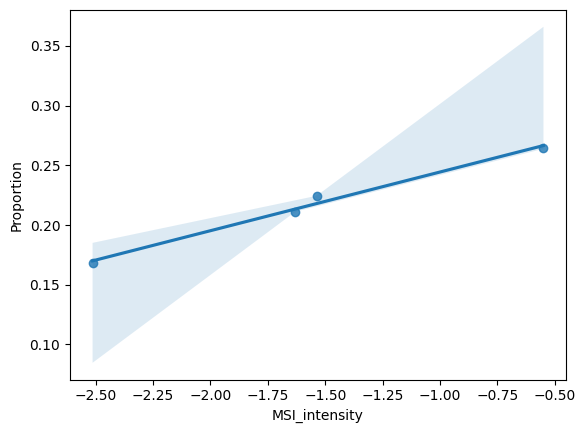

In [41]:
joanito_patient_order_by_MSI_intensity     = ['CRC2817', 'CRC2783', 'SC035', 'SC044']
AuthorCellTypeLvl1_ProportionByPatient_oi = AuthorCellTypeLvl1_ProportionByPatient[(AuthorCellTypeLvl1_ProportionByPatient['Author_CellType_lvl_1']=='McDC') ]
sns.regplot(data=AuthorCellTypeLvl1_ProportionByPatient_oi, x='MSI_intensity', y='Proportion',
            )

stats.pearsonr( x=AuthorCellTypeLvl1_ProportionByPatient_oi['MSI_intensity'], y=AuthorCellTypeLvl1_ProportionByPatient_oi['Proportion'] )

### level 2 (Manual Annotation)

In [48]:
ManualCellTypeLvl2_ProportionByPatient = list()

for PatientID, edf in adata_joanito_tumorSamples[(adata_joanito_tumorSamples.obs['Author_CellType_lvl_1']!='Epihelial')].obs.groupby('PatientID', observed=True,):
    for Manual_CellType_lvl_2, edf2 in edf.groupby('Manual_CellType_lvl_2', observed=True):
        ManualCellTypeLvl2_ProportionByPatient.append( [PatientID, Manual_CellType_lvl_2, edf2.iloc[0].Author_CellType_lvl_1, len(edf2), len(edf2)/len(edf), ] )
        
ManualCellTypeLvl2_ProportionByPatient = pd.DataFrame(ManualCellTypeLvl2_ProportionByPatient, columns=['PatientID', 'Manual_CellType_lvl_2', 'Author_CellType_lvl_1', 'Count', 'Proportion',])

ManualCellTypeLvl2_ProportionByPatient['MSI_intensity'] = [ dict_PatientID_to_AvgSTRDiff[PID] for PID in ManualCellTypeLvl2_ProportionByPatient['PatientID'] ]
ManualCellTypeLvl2_ProportionByPatient['TumorCellCount'] = [ dict_PatientID_to_TumorCellCount[PID] for PID in ManualCellTypeLvl2_ProportionByPatient['PatientID'] ]
ManualCellTypeLvl2_ProportionByPatient['PerTumorCell'] = [ tup.Count/tup.TumorCellCount for tup in ManualCellTypeLvl2_ProportionByPatient.itertuples() ]

In [52]:
dict_CT_to_Cor = dict()
for Manual_CellType_lvl_2, edf in ManualCellTypeLvl2_ProportionByPatient.groupby('Manual_CellType_lvl_2', observed=True):
    try:
        dict_CT_to_Cor[Manual_CellType_lvl_2] = (stats.pearsonr( x=edf['MSI_intensity'], y=edf['Proportion'] )[0], stats.pearsonr( x=edf['MSI_intensity'], y=edf['Proportion'] )[1])
    except ValueError:
        dict_CT_to_Cor[Manual_CellType_lvl_2] = ( None, None )
        
ManualCellTypeLvl2_ProportionByPatient['r'] = [ dict_CT_to_Cor[Author_CellType_lvl_2][0] for Author_CellType_lvl_2 in ManualCellTypeLvl2_ProportionByPatient['Manual_CellType_lvl_2'] ]
ManualCellTypeLvl2_ProportionByPatient['p'] = [ dict_CT_to_Cor[Author_CellType_lvl_2][1] for Author_CellType_lvl_2 in ManualCellTypeLvl2_ProportionByPatient['Manual_CellType_lvl_2'] ]

In [56]:
set(ManualCellTypeLvl2_ProportionByPatient['Manual_CellType_lvl_2'])

{'ACTA2+ Fibroblast',
 'CD4+ T',
 'CD8+ T',
 'Endothelial',
 'Fibroblast',
 'GC B',
 'Glial',
 'Goblet',
 'IGHA+ Plasma',
 'IGHG+ Plasma',
 'ILC3',
 'Macrophage',
 'Mast',
 'Memory B',
 'Monocyte',
 'N/A',
 'NK',
 'Naive B',
 'Pericyte',
 'SMC',
 'SOX6+ Fibroblast',
 'TA 1',
 'Tumor epithelial',
 'Vδ2+ T',
 'cDC',
 'pDC'}

PearsonRResult(statistic=0.0398069237052453, pvalue=0.9601930762947548)

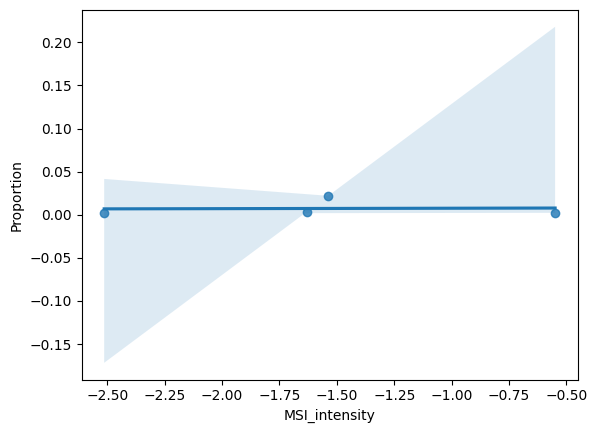

In [72]:
joanito_patient_order_by_MSI_intensity     = ['CRC2817', 'CRC2783', 'SC035', 'SC044']
ManualCellTypeLvl2_ProportionByPatient_oi = ManualCellTypeLvl2_ProportionByPatient[(ManualCellTypeLvl2_ProportionByPatient['Manual_CellType_lvl_2'].isin(['cDC'])) ]

sns.regplot(data=ManualCellTypeLvl2_ProportionByPatient_oi, x='MSI_intensity', y='Proportion',
            )

stats.pearsonr( x=ManualCellTypeLvl2_ProportionByPatient_oi['MSI_intensity'], y=ManualCellTypeLvl2_ProportionByPatient_oi['Proportion'] )

### level 1 + TissueEnrichmentAnalysis

In [84]:
AuthorCellTypeLvl1_ProportionByPatient = list()

for PatientID, edf in adata_joanito[(adata_joanito.obs['Author_CellType_lvl_1']!='Epithelial') & (adata_joanito.obs['BiopsySite2']!='LymphNode')].obs.groupby('PatientID', observed=True,):
    for BiopsySite, edf2 in edf.groupby('BiopsySite2', observed=True):
        for Author_CellType_lvl_1, edf3 in edf2.groupby('Author_CellType_lvl_1', observed=True):
            AuthorCellTypeLvl1_ProportionByPatient.append( [PatientID, 
                                                            BiopsySite, 
                                                            Author_CellType_lvl_1,
                                                            len(edf3), 
                                                            len(edf2), 
                                                            len(edf3)/len(edf2),
                                                            ] )
        
AuthorCellTypeLvl1_ProportionByPatient = pd.DataFrame(AuthorCellTypeLvl1_ProportionByPatient, columns=['PatientID', 
                                                                                                       'BiopsySite',
                                                                                                       'Author_CellType_lvl_1',
                                                                                                       'CountWithinSample', 
                                                                                                       'TotalCount',
                                                                                                       'Proportion',])

AuthorCellTypeLvl1_ProportionByPatient['MSI_intensity'] = [ dict_PatientID_to_AvgSTRDiff[PID] for PID in AuthorCellTypeLvl1_ProportionByPatient['PatientID'] ]
AuthorCellTypeLvl1_ProportionByPatient['TumorCellCount'] = [ dict_PatientID_to_TumorCellCount[PID] for PID in AuthorCellTypeLvl1_ProportionByPatient['PatientID'] ]


dict_CT_to_Cor = dict()
for Author_CellType_lvl_1, edf in AuthorCellTypeLvl1_ProportionByPatient[(AuthorCellTypeLvl1_ProportionByPatient['BiopsySite']=='Tumor')].groupby('Author_CellType_lvl_1', observed=True):
    try:
        dict_CT_to_Cor[Author_CellType_lvl_1] = (stats.pearsonr( x=edf['MSI_intensity'], y=edf['Proportion'] )[0], stats.pearsonr( x=edf['MSI_intensity'], y=edf['Proportion'] )[1])
    except ValueError:
        dict_CT_to_Cor[Author_CellType_lvl_1] = ( None, None )
for Author_CellType_lvl_1 in AuthorCellTypeLvl1_ProportionByPatient['Author_CellType_lvl_1']:
    try: dict_CT_to_Cor[Author_CellType_lvl_1]
    except KeyError: dict_CT_to_Cor[Author_CellType_lvl_1] = ( None, None )
        
AuthorCellTypeLvl1_ProportionByPatient['r'] = [ dict_CT_to_Cor[Author_CellType_lvl_1][0] for Author_CellType_lvl_1 in AuthorCellTypeLvl1_ProportionByPatient['Author_CellType_lvl_1'] ]
AuthorCellTypeLvl1_ProportionByPatient['p'] = [ dict_CT_to_Cor[Author_CellType_lvl_1][1] for Author_CellType_lvl_1 in AuthorCellTypeLvl1_ProportionByPatient['Author_CellType_lvl_1'] ]

In [85]:
dict_CellType_to_Enrichment = dict()
T_totalCellCount = sum(AuthorCellTypeLvl1_ProportionByPatient[AuthorCellTypeLvl1_ProportionByPatient['BiopsySite']=='Tumor']['CountWithinSample'])
N_totalCellCount = sum(AuthorCellTypeLvl1_ProportionByPatient[AuthorCellTypeLvl1_ProportionByPatient['BiopsySite']=='Normal']['CountWithinSample'])
print(T_totalCellCount, N_totalCellCount)
dict_BiopsySite_to_TotalCount = { 'Tumor' : T_totalCellCount,'Normal' : N_totalCellCount }

for CellType, edf in AuthorCellTypeLvl1_ProportionByPatient.groupby('Author_CellType_lvl_1'):
    # dict_BiopsySite_to_Proportion = { tup.BiopsySite : tup.Proportion for tup in edf.itertuples() }
    try:
        dict_BiopsySite_to_Proportion = { BiopsySite : sum(edf2['CountWithinSample'])/dict_BiopsySite_to_TotalCount[BiopsySite] for BiopsySite, edf2 in edf.groupby('BiopsySite') }
        dict_CellType_to_Enrichment[CellType] = calcSampleEnrichment(dict_BiopsySite_to_Proportion['Tumor'], dict_BiopsySite_to_Proportion['Normal'])

    except: 
        print(CellType, sum(edf['CountWithinSample']))
        dict_CellType_to_Enrichment[CellType] = None
        continue 

AuthorCellTypeLvl1_ProportionByPatient['TissueEnrichment'] = [ dict_CellType_to_Enrichment[CellType] for CellType in AuthorCellTypeLvl1_ProportionByPatient['Author_CellType_lvl_1'] ]

24058 11947


In [90]:
AuthorCellTypeLvl1_ProportionByPatient[AuthorCellTypeLvl1_ProportionByPatient['Author_CellType_lvl_1']=='B']

,PatientID,BiopsySite,Author_CellType_lvl_1,CountWithinSample,TotalCount,Proportion,MSI_intensity,TumorCellCount,r,p,TissueEnrichment,significant
0,CRC2783,Normal,B,536,3601,0.148848,-1.630885,769,0.133349,0.866651,-0.890025,False
9,CRC2783,Tumor,B,241,9168,0.026287,-1.630885,769,0.133349,0.866651,-0.890025,False
18,CRC2817,Normal,B,174,3743,0.046487,-0.548899,1053,0.133349,0.866651,-0.890025,False
27,CRC2817,Tumor,B,790,10245,0.077111,-0.548899,1053,0.133349,0.866651,-0.890025,False
37,SC035,Normal,B,278,1200,0.231667,-1.537283,1019,0.133349,0.866651,-0.890025,False
45,SC035,Tumor,B,163,2437,0.066886,-1.537283,1019,0.133349,0.866651,-0.890025,False
53,SC044,Normal,B,259,3403,0.076109,-2.513823,373,0.133349,0.866651,-0.890025,False
62,SC044,Tumor,B,161,2208,0.072917,-2.513823,373,0.133349,0.866651,-0.890025,False


In [105]:
adata_joanito[(adata_joanito.obs['BiopsySite2']=='Tumor') & 
              (adata_joanito.obs['Author_CellType_lvl_1']!='Epithelial')]

View of AnnData object with n_obs × n_vars = 24058 × 2000
    obs: 'doublet_score', 'predicted_doublet', 'SampleID', 'PatientID', 'BiopsySite', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'Identifier', 'Author_CellType_lvl_1', 'Author_CellType_lvl_2', 'n_genes', 'leiden', 'AvgSTRDiff', 'StdSTRDiff', 'NumSTRLoci', 'MSI', 'Manual_CellType_lvl_1', 'Manual_CellType_lvl_2', 'BiopsySite2'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'Author_CellType_lvl_1_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [108]:
1247/11947

0.10437766803381603

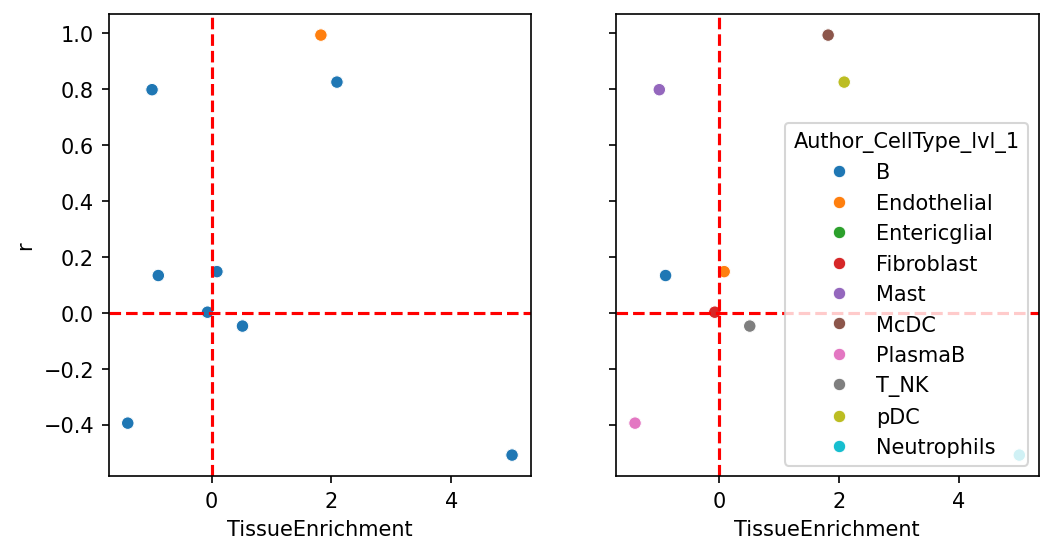

In [87]:
AuthorCellTypeLvl1_ProportionByPatient['significant'] = [ bool(p<=0.05) for p in AuthorCellTypeLvl1_ProportionByPatient['p'] ]
fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=150, sharey=True, sharex=True)
sns.scatterplot(data=AuthorCellTypeLvl1_ProportionByPatient, x='TissueEnrichment', y='r', hue='significant', legend=None, ax=axes[0])
axes[0].axhline(0, color='r', ls='--')
axes[0].axvline(0, color='r', ls='--')

sns.scatterplot(data=AuthorCellTypeLvl1_ProportionByPatient, x='TissueEnrichment', y='r', hue='Author_CellType_lvl_1', legend=True, ax=axes[1])
axes[1].axhline(0, color='r', ls='--')
axes[1].axvline(0, color='r', ls='--')

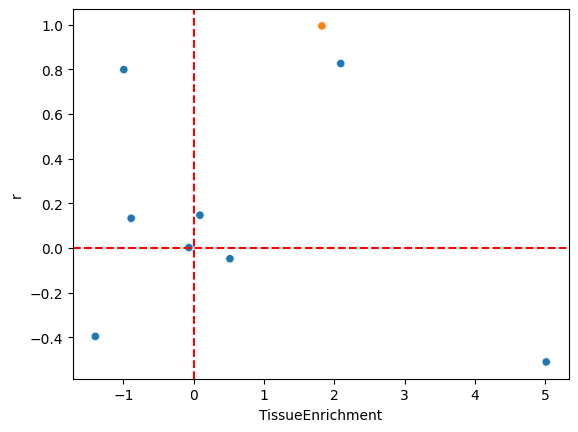

In [88]:
sns.scatterplot(data=AuthorCellTypeLvl1_ProportionByPatient, x='TissueEnrichment', y='r', hue='significant', legend=None)
plt.axhline(0, color='r', ls='--')
plt.axvline(0, color='r', ls='--')

### level 2 + TissueEnrichmentAnalysis

In [112]:
ManualCellTypeLvl2_ProportionByPatient = list()

for PatientID, edf in adata_joanito[(adata_joanito.obs['Author_CellType_lvl_1']!='Epithelial') & (adata_joanito.obs['BiopsySite2']!='LymphNode')].obs.groupby('PatientID', observed=True,):
    for BiopsySite, edf2 in edf.groupby('BiopsySite2', observed=True):
        for Manual_CellType_lvl_2, edf3 in edf2.groupby('Manual_CellType_lvl_2', observed=True):
            ManualCellTypeLvl2_ProportionByPatient.append( [PatientID, 
                                                            BiopsySite, 
                                                            Manual_CellType_lvl_2,
                                                            edf3.iloc[0].Author_CellType_lvl_1, 
                                                            len(edf3), 
                                                            len(edf2), 
                                                            len(edf3)/len(edf2),
                                                            ] )
        
ManualCellTypeLvl2_ProportionByPatient = pd.DataFrame(ManualCellTypeLvl2_ProportionByPatient, columns=['PatientID', 
                                                                                                       'BiopsySite',
                                                                                                       'Manual_CellType_lvl_2', 
                                                                                                       'Author_CellType_lvl_1',
                                                                                                       'CountWithinSample', 
                                                                                                       'TotalCount',
                                                                                                       'Proportion',])

ManualCellTypeLvl2_ProportionByPatient['MSI_intensity'] = [ dict_PatientID_to_AvgSTRDiff[PID] for PID in ManualCellTypeLvl2_ProportionByPatient['PatientID'] ]
ManualCellTypeLvl2_ProportionByPatient['TumorCellCount'] = [ dict_PatientID_to_TumorCellCount[PID] for PID in ManualCellTypeLvl2_ProportionByPatient['PatientID'] ]


dict_CT_to_Cor = dict()
for Manual_CellType_lvl_2, edf in ManualCellTypeLvl2_ProportionByPatient[(ManualCellTypeLvl2_ProportionByPatient['BiopsySite']=='Tumor')].groupby('Manual_CellType_lvl_2', observed=True):
    try:
        dict_CT_to_Cor[Manual_CellType_lvl_2] = (stats.pearsonr( x=edf['MSI_intensity'], y=edf['Proportion'] )[0], stats.pearsonr( x=edf['MSI_intensity'], y=edf['Proportion'] )[1])
    except ValueError:
        dict_CT_to_Cor[Manual_CellType_lvl_2] = ( None, None )
for Manual_CellType_lvl_2 in ManualCellTypeLvl2_ProportionByPatient['Manual_CellType_lvl_2']:
    try: dict_CT_to_Cor[Manual_CellType_lvl_2]
    except KeyError: dict_CT_to_Cor[Manual_CellType_lvl_2] = ( None, None )
        
ManualCellTypeLvl2_ProportionByPatient['r'] = [ dict_CT_to_Cor[Manual_CellType_lvl_2][0] for Manual_CellType_lvl_2 in ManualCellTypeLvl2_ProportionByPatient['Manual_CellType_lvl_2'] ]
ManualCellTypeLvl2_ProportionByPatient['p'] = [ dict_CT_to_Cor[Manual_CellType_lvl_2][1] for Manual_CellType_lvl_2 in ManualCellTypeLvl2_ProportionByPatient['Manual_CellType_lvl_2'] ]

In [113]:


dict_CellType_to_Enrichment = dict()
T_totalCellCount = sum(ManualCellTypeLvl2_ProportionByPatient[ManualCellTypeLvl2_ProportionByPatient['BiopsySite']=='Tumor']['CountWithinSample'])
N_totalCellCount = sum(ManualCellTypeLvl2_ProportionByPatient[ManualCellTypeLvl2_ProportionByPatient['BiopsySite']=='Normal']['CountWithinSample'])
print(T_totalCellCount, N_totalCellCount)
dict_BiopsySite_to_TotalCount = { 'Tumor' : T_totalCellCount,'Normal' : N_totalCellCount }

for CellType, edf in ManualCellTypeLvl2_ProportionByPatient.groupby('Manual_CellType_lvl_2'):
    # dict_BiopsySite_to_Proportion = { tup.BiopsySite : tup.Proportion for tup in edf.itertuples() }
    try:
        dict_BiopsySite_to_Proportion = { BiopsySite : sum(edf2['CountWithinSample'])/dict_BiopsySite_to_TotalCount[BiopsySite] for BiopsySite, edf2 in edf.groupby('BiopsySite') }
        dict_CellType_to_Enrichment[CellType] = calcSampleEnrichment(dict_BiopsySite_to_Proportion['Tumor'], dict_BiopsySite_to_Proportion['Normal'])

    except: 
        print(CellType, sum(edf['CountWithinSample']))
        dict_CellType_to_Enrichment[CellType] = None
        continue 

ManualCellTypeLvl2_ProportionByPatient['TissueEnrichment'] = [ dict_CellType_to_Enrichment[CellType] for CellType in ManualCellTypeLvl2_ProportionByPatient['Manual_CellType_lvl_2'] ]

24058 11947
Vδ1+ T 216


ValueError: Axes(0.547727,0.11;0.352273x0.77) has no legend attached.

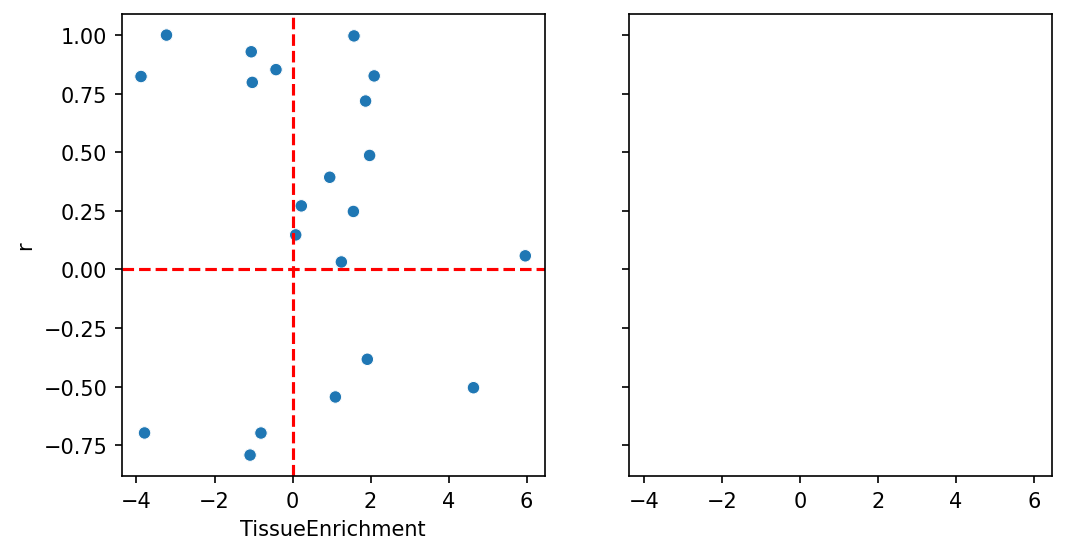

In [115]:
ManualCellTypeLvl2_ProportionByPatient['significant'] = [ bool(p<=0.05) for p in ManualCellTypeLvl2_ProportionByPatient['p'] ]
fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=150, sharey=True, sharex=True)
sns.scatterplot(data=ManualCellTypeLvl2_ProportionByPatient, x='TissueEnrichment', y='r', hue='significant', legend=None, ax=axes[0])
axes[0].axhline(0, color='r', ls='--')
axes[0].axvline(0, color='r', ls='--')

f = sns.scatterplot(data=ManualCellTypeLvl2_ProportionByPatient[ManualCellTypeLvl2_ProportionByPatient['significant']==True], x='TissueEnrichment', y='r', hue='Manual_CellType_lvl_2', legend=True, ax=axes[1])
sns.move_legend(f, "upper left", bbox_to_anchor=(1, 1))
axes[1].axhline(0, color='r', ls='--')
axes[1].axvline(0, color='r', ls='--')

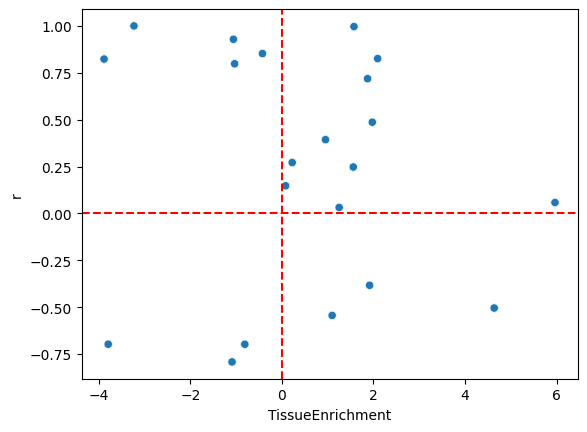

In [118]:
sns.scatterplot(data=ManualCellTypeLvl2_ProportionByPatient, x='TissueEnrichment', y='r', hue='significant', legend=None)
plt.axhline(0, color='r', ls='--')
plt.axvline(0, color='r', ls='--')